In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import random
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict

from pyro.infer import MCMC, NUTS, HMC

#from iterative_sir.sampling_utils.sir_ais_sampling import sir_independent_dynamics, sir_correlated_dynamics
from iterative_sir.sampling_utils.ebm_sampling import MALA

from iterative_sir.sampling_utils.adaptive_mc import adaptive_sir_correlated_dynamics, CISIR, Ex2MCMC, FlowMCMC
from iterative_sir.sampling_utils.adaptive_sir_loss import *

from iterative_sir.sampling_utils.flows import RNVP


from iterative_sir.sampling_utils.distributions import IndependentNormal, BayesianLogRegression
from iterative_sir.sampling_utils.logistic_regression import ClassificationDatasetFactory

from iterative_sir.sampling_utils.metrics import ESS, acl_spectrum

In [3]:
from scipy.stats import gaussian_kde

def plot_kde(samples, dims=[0, 1], ax_lims = [(-2,9), (-2,4)], max_pts=200, fig=None, cmap=None):
    if fig is None: 
      plt.close()
      fig = plt.figure(figsize=(5, 5)) #, dpi=300)

    X, Y = np.mgrid[ax_lims[0][0]:ax_lims[0][1]:100j, ax_lims[1][0]:ax_lims[1][1]:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_inp = np.stack([samples[:, dims[0]], samples[:, dims[1]]], 1).T
    kernel = gaussian_kde(kde_inp)
    Z = np.reshape(kernel(positions).T, X.shape)

    if cmap is None:
        cmap = plt.cm.gist_earth_r
        
    plt.imshow(np.rot90(Z), cmap=cmap,
          extent=[ax_lims[0][0], ax_lims[0][1], ax_lims[1][0], ax_lims[1][1]], alpha=0.5)

    #plt.plot(samples[-max_pts:, dims[0]], samples[-max_pts:, dims[1]], 'k.', markersize=2)
    plt.xlim([ax_lims[0][0], ax_lims[0][1]])
    plt.ylim([ax_lims[1][0], ax_lims[1][1]])

    plt.axis('square')

    return fig


In [4]:
from matplotlib.colors import LinearSegmentedColormap

def get_custom_cmap(cmap, name):
    ncolors = 256
    color_array = cmap(range(ncolors))

    # change alpha values
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name=name,colors=color_array)

    # register this new colormap with matplotlib
    plt.register_cmap(cmap=map_object)
    

get_custom_cmap(plt.cm.Blues, 'blue_alpha')
get_custom_cmap(plt.cm.Reds, 'red_alpha')

In [5]:
from pathlib import Path
figpath = Path('../figs')
data_root = Path('../data')

In [6]:
device = torch.device('cpu')

In [7]:
dataset_args = edict()

dataset_name = 'covertype'
n_steps = 3 * int(1000)
dataset_args.c1 = 3
dataset_args.c2 = 5

# dataset_name = 'susy'
# dataset_args.c1 = 0
# dataset_args.c2 = 1

# dataset_name = 'mnist'
# n_steps = 3 * int(1000)
# dataset_args.c1 = 5
# dataset_args.c2 = 6

# dataset_name = 'breast'
# n_steps = 3 * int(10000)
# dataset_args.c1 = 0
# dataset_args.c2 = 1

# dataset_name = 'eeg'
# n_steps = 3 * int(1000)

# dataset_name = 'swiss'
# n_steps = 3 * int(10000)

# dataset_name = 'pima'
# n_steps = 3 * int(10000)

dataset = ClassificationDatasetFactory(data_root).get_dataset(dataset_name, **dataset_args)


target_args = edict()
target_args.device = device
target = BayesianLogRegression(dataset, **target_args)
dim = target.d

Original size: 36197, outliers size: 688


In [8]:
dataset.x_train.shape

torch.Size([35509, 55])

In [9]:
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = torch.ones(dim).to(device)
proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(**proposal_args)

In [10]:
args = edict()
args.batch_size = 30
args.device = device


#int(1e5) #100000

trunc_chain_len = int(0.5 * n_steps)

N = 5

methods_calls = defaultdict(tuple)

samples = []
names = []
ess_vals = []
times = []

In [18]:
# method_args = edict()
# method_args.n_steps = n_steps
# method_args.N = N
# methods_calls['isir'] = partial(CISIR(N), **method_args)
# #methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)

# method_args = edict()
# method_args.n_steps = n_steps
# method_args.N = N
# # method_args.alpha = 0.9
# method_args.corr_coef = 0.9
# method_args.bernoulli_prob_corr = 0.5
# methods_calls['cisir'] = partial(CISIR(N), **method_args)

# method_args = edict()
# method_args.n_steps = n_steps
# method_args.grad_step = 1e-2
# method_args.noise_scale = (2 * method_args.grad_step)**.5
# method_args.adapt_stepsize = True
# methods_calls['mala'] = partial(MALA(dim), **method_args)

method_args = edict()
method_args.n_steps = n_steps
method_args.mala_steps = 1
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = N
method_args.corr_coef = 0.0
method_args.bernoulli_prob_corr = 0.0
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala_wo_cor'] = partial(Ex2MCMC(N), **method_args)

# method_args = edict()
# method_args.n_steps = n_steps
# method_args.mala_steps = 1
# method_args.grad_step = 1e-2
# method_args.noise_scale = (2 * method_args.grad_step)**.5
# method_args.N = N
# method_args.corr_coef = 0.9
# method_args.bernoulli_prob_corr = 0.5
# method_args.adapt_stepsize = True
# methods_calls['ex2_mcmc_mala_w_corr'] = partial(Ex2MCMC(N), **method_args)


for method_name, call in methods_calls.items():

    start = proposal.sample([args.batch_size])

    s = time.time()

    out = call(start, target, proposal)
    e = time.time()
    elapsed = (e - s) #/ 60
    if isinstance(out, tuple):
        sample = out[0]
    else:
        sample = out

    ess_arr = []
    sample = torch.stack(sample, 0).detach().cpu().numpy()
    trunc_sample = sample[-trunc_chain_len:]
    batch_size = sample.shape[1]
    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...])))
    assert ess.shape[0] == batch_size
    print(f'Method: {method_name}, ESS: {ess.mean():.4f}, sampling time: {elapsed:.2f}, ESS/s: {ess.mean()*n_steps/elapsed:.2f}')

    samples.append(trunc_sample)
    names.append(method_name)
    ess_vals.append(ess)
    times.append(elapsed)


100%|██████████| 3000/3000 [03:27<00:00, 14.49it/s]


Method: ex2_mcmc_mala_wo_cor, ESS: 0.0061, sampling time: 207.12, ESS/s: 0.09


In [24]:
from iterative_sir.sampling_utils.adaptive_mc import FlowMCMC

torch.autograd.set_detect_anomaly(False)

batch_size = 100
loss = "mix_kl"
optimizer = 'adam'
flow = RNVP(num_flows=4, dim=dim)

method_args = edict()
method_args.n_steps = 1
method_args.N = N
# method_args.alpha = 0.9
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
cisir = CISIR(N)
mcmc_call = partial(cisir, **method_args)

flow_mcmc = FlowMCMC(target, proposal, flow, optimizer, loss, mcmc_call, batch_size=batch_size, lr=1e-2)
out_samples = flow_mcmc.train(n_steps=200) #100) #100) #200)

100%|██████████| 200/200 [00:07<00:00, 27.18it/s]


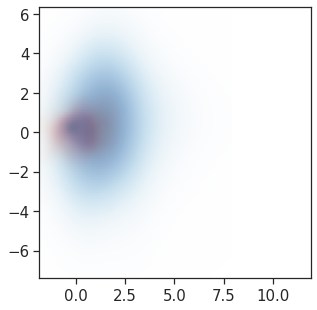

In [25]:
z_0 = proposal.sample((1000,))
z_1, _ = flow(z_0)

dim1 = 1 #16
dim2 = 2 #17

prior = z_0.detach().cpu().numpy()
poster = z_1.detach().cpu().numpy()

up_quantile = 0.95
low_quantile = 0.05

ax_lims1 = [(np.quantile(prior[:, dim1], low_quantile), np.quantile(prior[:, dim1], up_quantile)), (np.quantile(prior[:, dim2], low_quantile), np.quantile(prior[:, dim2], up_quantile))]
ax_lims2 = [(np.quantile(poster[:, dim1], low_quantile), np.quantile(poster[:, dim1], up_quantile)), (np.quantile(poster[:, dim2], low_quantile), np.quantile(poster[:, dim2], up_quantile))]

ax_lims = [(min(ax_lims1[0][0], ax_lims2[0][0]), max(ax_lims1[0][1], ax_lims2[0][1])), (min(ax_lims1[1][0], ax_lims2[1][0]), max(ax_lims1[1][1], ax_lims2[1][1]))]
fig = plot_kde(prior, [dim1, dim2], ax_lims=ax_lims, cmap = 'red_alpha')

plot_kde(poster, [dim1, dim2], ax_lims=ax_lims, fig=fig, cmap = 'blue_alpha')

plt.show()

In [38]:
start = proposal.sample([args.batch_size])

s = time.time()

# alpha = 0.9
corr_coef = 0.9
bernoulli_prob_corr = 0.5
method_name = 'cisir_w_flow'
#out = adaptive_sir_correlated_dynamics(start, target, proposal, n_steps, N, corr_coef, bernoulli_prob_corr, flow)
out = cisir(start, target, proposal, n_steps, N, corr_coef, bernoulli_prob_corr, flow)
e = time.time()
elapsed = (e - s) #/ 60
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out

ess_arr = []
sample = torch.stack(sample, 0).detach().cpu().numpy()
trunc_sample = sample[-trunc_chain_len:]
batch_size = sample.shape[1]
ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...])))
assert ess.shape[0] == batch_size
print(f'Method: {method_name}, ESS: {ess.mean():.4f}, sampling time: {elapsed:.2f}, ESS/s: {ess.mean()*n_steps/elapsed:.2f}')

samples.append(trunc_sample)
names.append(method_name)
ess_vals.append(ess)
times.append(elapsed)


100%|██████████| 3000/3000 [00:15<00:00, 191.42it/s]


Method: cisir_w_flow, ESS: 0.0098, sampling time: 15.68, ESS/s: 1.87


In [15]:
batch_size = 100
loss = "mix_kl"
optimizer = 'adam'
flow = RNVP(num_flows=4, dim=dim)

grad_step = 1e-2

method_args = edict()
method_args.n_steps = 1
method_args.N = N
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
method_args.grad_step = grad_step
method_args.noise_scale = (2 * grad_step) ** .5
method_args.adapt_stepsize = True
method_args.mala_steps = 1


ex2mcmc = Ex2MCMC(N)
mcmc_call = partial(ex2mcmc, **method_args)
flow_mcmc = FlowMCMC(target, proposal, flow, optimizer, loss, mcmc_call, batch_size=batch_size, lr=1e-2)
out_samples = flow_mcmc.train(n_steps=200) #200)

100%|██████████| 200/200 [00:07<00:00, 27.14it/s]


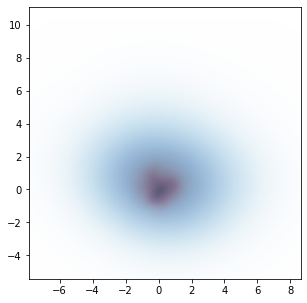

In [16]:
z_0 = proposal.sample((1000,))
z_1, _ = flow(z_0)

dim1 = 1 #16
dim2 = 2 #17

prior = z_0.detach().cpu().numpy()
poster = z_1.detach().cpu().numpy()

up_quantile = 0.95
low_quantile = 0.05

ax_lims1 = [(np.quantile(prior[:, dim1], low_quantile), np.quantile(prior[:, dim1], up_quantile)), (np.quantile(prior[:, dim2], low_quantile), np.quantile(prior[:, dim2], up_quantile))]
ax_lims2 = [(np.quantile(poster[:, dim1], low_quantile), np.quantile(poster[:, dim1], up_quantile)), (np.quantile(poster[:, dim2], low_quantile), np.quantile(poster[:, dim2], up_quantile))]

ax_lims = [(min(ax_lims1[0][0], ax_lims2[0][0]), max(ax_lims1[0][1], ax_lims2[0][1])), (min(ax_lims1[1][0], ax_lims2[1][0]), max(ax_lims1[1][1], ax_lims2[1][1]))]
fig = plot_kde(prior, [dim1, dim2], ax_lims=ax_lims, cmap = 'red_alpha')

plot_kde(poster, [dim1, dim2], ax_lims=ax_lims, fig=fig, cmap = 'blue_alpha')

plt.show()

In [17]:
start = proposal.sample([args.batch_size])

s = time.time()

grad_step = 1e-2
method_name = 'ex2_mcmc_w_flow'
out = ex2mcmc(start, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
                        mala_steps=1, corr_coef=0.9, bernoulli_prob_corr=0.5, flow=flow, adapt_stepsize=True, verbose=True)
e = time.time()
elapsed = (e - s) #/ 60
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out

ess_arr = []
sample = torch.stack(sample, 0).detach().cpu().numpy()
trunc_sample = sample[-trunc_chain_len:]
batch_size = sample.shape[1]
ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...])))
assert ess.shape[0] == batch_size
print(f'Method: {method_name}, ESS: {ess.mean():.4f}, sampling time: {elapsed:.2f}, ESS/s: {ess.mean()*n_steps/elapsed:.2f}')

samples.append(trunc_sample)
names.append(method_name)
ess_vals.append(ess)
times.append(elapsed)


100%|██████████| 3000/3000 [00:25<00:00, 118.39it/s]


Method: ex2_mcmc_w_flow, ESS: 0.0074, sampling time: 25.35, ESS/s: 0.87


In [18]:
# from pyro.infer import MCMC, NUTS, HMC

# def energy(z):
#     z = z['points']
#     return target.log_prob(z).sum()


# #kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
# kernel_true = NUTS(potential_fn=energy, full_mass = True)
# init_samples = proposal.sample((2,))

# init_params = {'points': init_samples}
# mcmc_true = MCMC(kernel=kernel_true, num_samples=n_steps,warmup_steps = 1000, initial_params=init_params)
# mcmc_true.run()

# q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()
# nuts_samples = np.array(q_true.view(-1, dim))

# np.save('nuts_samples', nuts_samples)

Classification Error

In [19]:
def classification(theta, x, y):
    #pdb.set_trace()
    P = 1. / (1. + torch.exp(-torch.matmul(x,theta.transpose(0,1))))
    ll =  y[...,None]*torch.log(torch.clamp(P, min=1e-10)) + (1-y[...,None])*torch.log(torch.clamp(1 - P, min=1e-10))
    return ll

In [13]:
ll_post = []
for test_samples in samples:
    chunk_len = 1000
    ll = 0
    for j in range(0, len(dataset.x_test), chunk_len):
        x_chunk = dataset.x_test[j : j + chunk_len]
        y_chunk = dataset.y_test[j : j + chunk_len]
        ll = ll + classification(torch.tensor(test_samples).view(-1, dim), x_chunk, y_chunk).exp().numpy().sum(0).reshape(test_samples.shape[:-1]).mean(0)
    ll_post.append(ll / len(dataset.x_test))
ll_post_plot = ll_post

In [14]:
import numpy as np

print(np.array(ll_post_plot).mean(1))
print(np.median(ll_post_plot, 1))

[0.8107073  0.8895499  0.780633   0.80866283 0.88883805]
[0.81057775 0.89113027 0.95383656 0.80622995 0.88927484]


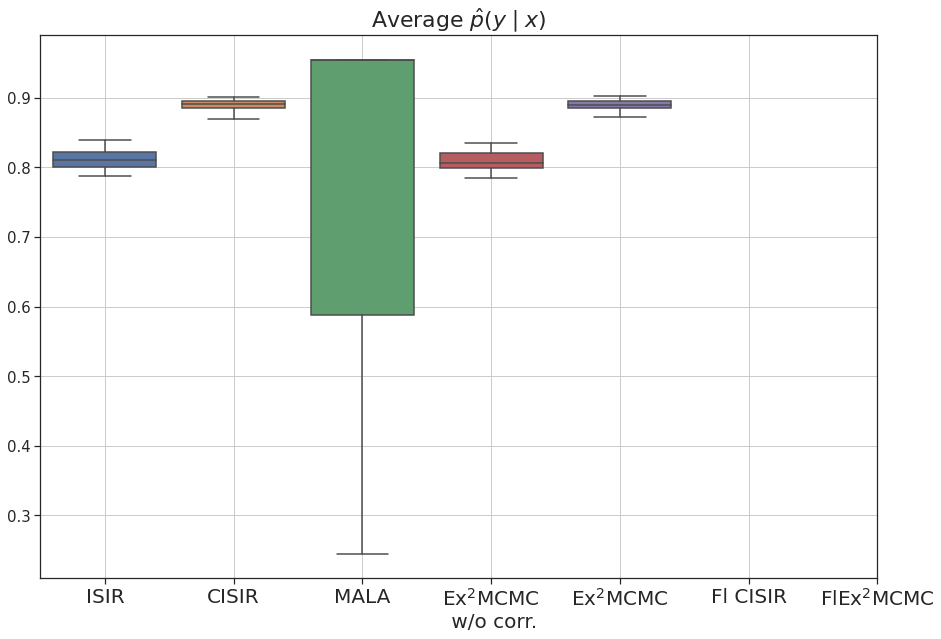

In [15]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

plt.figure(figsize = (15, 10))
# plt.rcParams.update({'font.size': 25})

SMALL_SIZE = 15 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 18 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#sns.violinplot(data = ll_post_plot)
sns.boxplot(data = ll_post_plot) #, s=6)
#sns.swarmplot(data = total_res15, size = 6, color = 'black', alpha = 1.)
#plt.hlines(y = 12.5, xmin = -0.5, xmax=5.5, color = 'red')

plt.title('Average $\hat{p}(y\mid x)$', fontsize = 22)
plt.xticks(np.arange(7),['ISIR', 'CISIR', 'MALA','Ex$^2$MCMC \n w/o corr.', 'Ex$^2$MCMC', 'Fl CISIR', 'FlEx$^2$MCMC'],
           fontsize = 20 )
plt.grid()

plt.savefig(Path(figpath, f'bayesian_logistic_regression_{dataset_name}.pdf'))

plt.show()

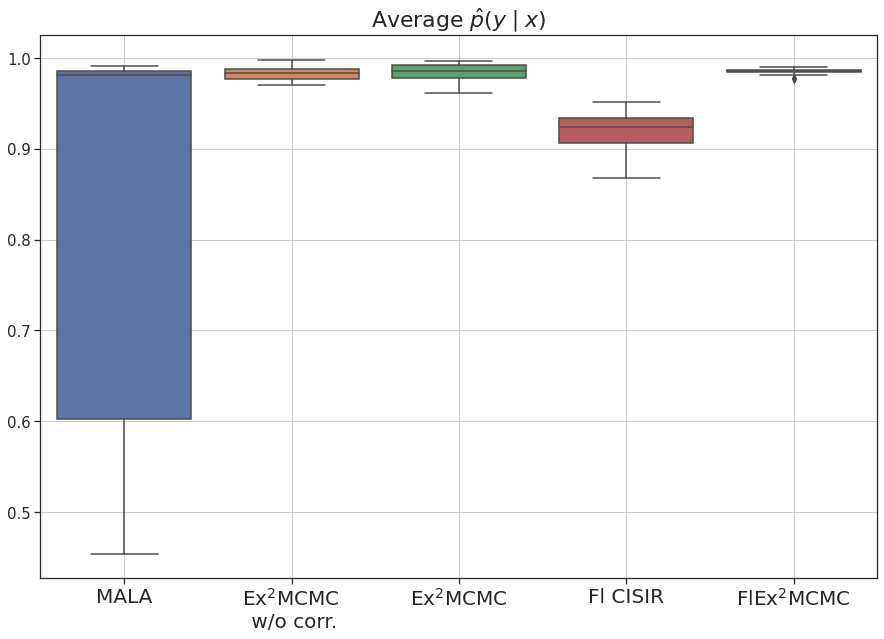

In [23]:
import seaborn as sns

plt.figure(figsize = (15, 10))
# plt.rcParams.update({'font.size': 25})

SMALL_SIZE = 15 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 18 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#sns.violinplot(data = ll_post_plot)
sns.boxplot(data = ll_post_plot[2:]) #, s=6)
#sns.swarmplot(data = total_res15, size = 6, color = 'black', alpha = 1.)
#plt.hlines(y = 12.5, xmin = -0.5, xmax=5.5, color = 'red')

plt.title('Average $\hat{p}(y\mid x)$', fontsize = 22)
plt.xticks(np.arange(5),['MALA','Ex$^2$MCMC \n w/o corr.', 'Ex$^2$MCMC', 'Fl CISIR', 'FlEx$^2$MCMC'],
           fontsize = 20 )
plt.grid()

plt.savefig(Path(figpath, f'bayesian_logistic_regression_{dataset_name}_2.pdf'))

plt.show()